# KPI & Chart Demo (Synthetic, Moodle-schema aligned)

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from datetime import date

# Locate data dir
BASE = Path(r"C:\xampp\htdocs\moodle\LMS\db\sample_data")


user_dim = pd.read_csv(BASE/'user_dim.csv')
course_dim = pd.read_csv(BASE/'course_dim.csv')
enrol = pd.read_csv(BASE/'enrol_fact.csv', parse_dates=['enrol_time'])
grade = pd.read_csv(BASE/'grade_fact.csv', parse_dates=['graded_at'])
subm = pd.read_csv(BASE/'submission_fact.csv', parse_dates=['submitted_at','duedate'])
events = pd.read_csv(BASE/'event_log_staging.csv', parse_dates=['timestamp'])
daily = pd.read_csv(BASE/'daily_course_kpi.csv', parse_dates=['date'])
pending = pd.read_csv(BASE/'pending_questions.csv')
rating_df = pd.read_csv(BASE/'course_rating.csv')
idea = pd.read_csv(BASE/'idea_dim.csv')
match = pd.read_csv(BASE/'mentor_match.csv')
actions = pd.read_csv(BASE/'action_item.csv', parse_dates=['due_date','done_at'])
meetings = pd.read_csv(BASE/'mentor_meeting.csv', parse_dates=['meeting_time'])
pitch = pd.read_csv(BASE/'pitch_readiness.csv')
mentor_profile = pd.read_csv(BASE/'mentor_profile.csv')
error_log = pd.read_csv(BASE/'error_log.csv', parse_dates=['timestamp'])
db_metrics = pd.read_csv(BASE/'db_metrics_daily.csv', parse_dates=['date'])
user_status = pd.read_csv(BASE/'user_status.csv', parse_dates=['blocked_at'])
mentor_avail = pd.read_csv(BASE/'mentor_availability.csv', parse_dates=['start_time','end_time'])
idea = pd.read_csv(BASE/'idea_dim.csv')
match = pd.read_csv(BASE/'mentor_match.csv', parse_dates=['matched_at'])
mentor_profile = pd.read_csv(BASE/'mentor_profile.csv')
pitch = pd.read_csv(BASE/'pitch_readiness.csv', parse_dates=['rated_at'])
meetings = pd.read_csv(BASE/'mentor_meeting.csv', parse_dates=['meeting_time'])
# TIME REFERENCE (date-safe)
today = daily['date'].max().date()
course_id = 1
course_name = course_dim.loc[course_dim.course_id==course_id,'fullname'].iat[0]
print(f"Using data path: {BASE}")
print(f"Course {course_id}: {course_name}")
print('Daily rows:', len(daily[daily.course_id==course_id]))
course_name


Using data path: C:\xampp\htdocs\moodle\LMS\db\sample_data
Course 1: Backend Internship
Daily rows: 153


'Backend Internship'

## Student — KPIs 


========== STUDENT DASHBOARD ==========
Course: Backend Internship
Progress: 100.0%
Avg grade: 69.6%
Due in 7 days: 0
Missing tasks: 74
Last active: 0 day(s) ago


C:\Users\minhs\AppData\Local\Temp\ipykernel_1200\2047678325.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x.score/x.maxscore).mean()*100)


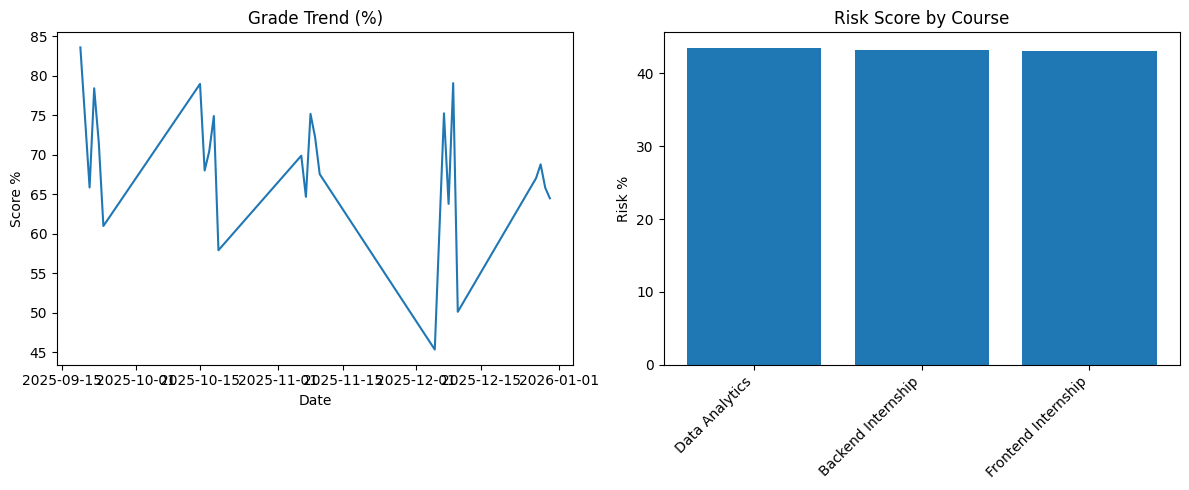


--- Due Soon Tasks (7 days) ---


,fullname,activity_id,duedate



--- Missing Tasks ---


,fullname,activity_id,duedate
47,Data Analytics,11,2025-09-20
48,Data Analytics,11,2025-09-20
49,Data Analytics,11,2025-09-20
50,Data Analytics,11,2025-09-20
51,Data Analytics,11,2025-09-20
...,...,...,...
14,Backend Internship,5,2025-12-27
45,Frontend Internship,10,2025-12-31
42,Frontend Internship,10,2025-12-31
43,Frontend Internship,10,2025-12-31


In [2]:
# 1. PROGRESS %  (status → card only)
total_items = grade[grade.course_id==course_id]['item_id'].nunique()

completed_items = subm[
    (subm.course_id==course_id) &
    (subm.submitted_at.notna())
]['activity_id'].nunique()

progress_pct = 100 * completed_items / total_items if total_items else 0



# 2. AVG GRADE (normalized %) + TREND
df_grade = grade[grade.course_id==course_id].copy()

avg_grade_pct = (
    (df_grade['score'] / df_grade['maxscore'])
    .mean() * 100
)

grade_trend = (
    df_grade
    .assign(date=df_grade['graded_at'].dt.date)
    .groupby('date')
    .apply(lambda x: (x.score/x.maxscore).mean()*100)
)



# 3. ASSIGNMENTS DUE (7 DAYS, ALL COURSES, NOT SUBMITTED)
due_soon = subm[
    (subm['duedate'].dt.date >= today) &
    (subm['duedate'].dt.date <= today + timedelta(days=7)) &
    (subm['submitted_at'].isna())
].merge(course_dim[['course_id','fullname']], on='course_id', how='left')

due_count = len(due_soon)



# 4. MISSING TASKS (OVERDUE + NOT SUBMITTED)
missing = subm[
    (subm['duedate'].dt.date < today) &
    (subm['submitted_at'].isna())
].merge(course_dim[['course_id','fullname']], on='course_id', how='left')

missing_count = len(missing)



# 5. LAST ACTIVE (date-safe, no negative)
last_active_date = (
    events[events.course_id==course_id]['timestamp']
    .max()
    .date()
)

days_inactive = (today - last_active_date).days



# 6. RISK SCORE PER COURSE (BAR CHART)
risk_rows = []

for cid in course_dim.course_id.unique():

    # -- grade --
    g = grade[grade.course_id==cid]
    avg_grade_pct = (g.score/g.maxscore).mean()*100 if len(g) else 0
    grade_risk = 100 - avg_grade_pct


    # -- missing --
    miss = subm[
        (subm.course_id==cid) &
        (subm.submitted_at.isna())
    ].shape[0]

    missing_risk = min(100, miss * 10)


    # -- inactivity --
    last = events[events.course_id==cid]['timestamp'].max().date()
    inactivity = (today - last).days

    inactivity_risk = min(100, inactivity/30 * 100)


    # -- final risk --
    risk = (((grade_risk +missing_risk + inactivity_risk) / 3))

    risk_rows.append((cid, risk))


risk_df = pd.DataFrame(risk_rows, columns=['course_id','risk_pct']) \
    .merge(course_dim[['course_id','fullname']], on='course_id') \
    .sort_values('risk_pct', ascending=False)




# ================= KPI CARDS =================
print("\n========== STUDENT DASHBOARD ==========")
print(f"Course: {course_name}")
print(f"Progress: {progress_pct:.1f}%")
print(f"Avg grade: {avg_grade_pct:.1f}%")
print(f"Due in 7 days: {due_count}")
print(f"Missing tasks: {missing_count}")
print(f"Last active: {days_inactive} day(s) ago")



# ================= CHARTS (ONLY 2) =================
plt.figure(figsize=(12,5))

# --- Grade trend (line) ---
plt.subplot(1,2,1)
grade_trend.plot()
plt.title("Grade Trend (%)")
plt.ylabel("Score %")
plt.xlabel("Date")

# --- Risk per course (bar) ---
plt.subplot(1,2,2)
plt.bar(risk_df['fullname'], risk_df['risk_pct'])
plt.xticks(rotation=45, ha='right')
plt.title("Risk Score by Course")
plt.ylabel("Risk %")

plt.tight_layout()
plt.show()



# ================= TASK LISTS =================
print("\n--- Due Soon Tasks (7 days) ---")
display(due_soon[['fullname','activity_id','duedate']].sort_values('duedate'))

print("\n--- Missing Tasks ---")
display(missing[['fullname','activity_id','duedate']].sort_values('duedate'))


## Teacher — KPIs


========== TEACHER DASHBOARD ==========
Course: Backend Internship
Total students: 23
Avg grade (class): 70.4%
Missing submissions: 17
Course rating: Start 4.13 (20 ratings)


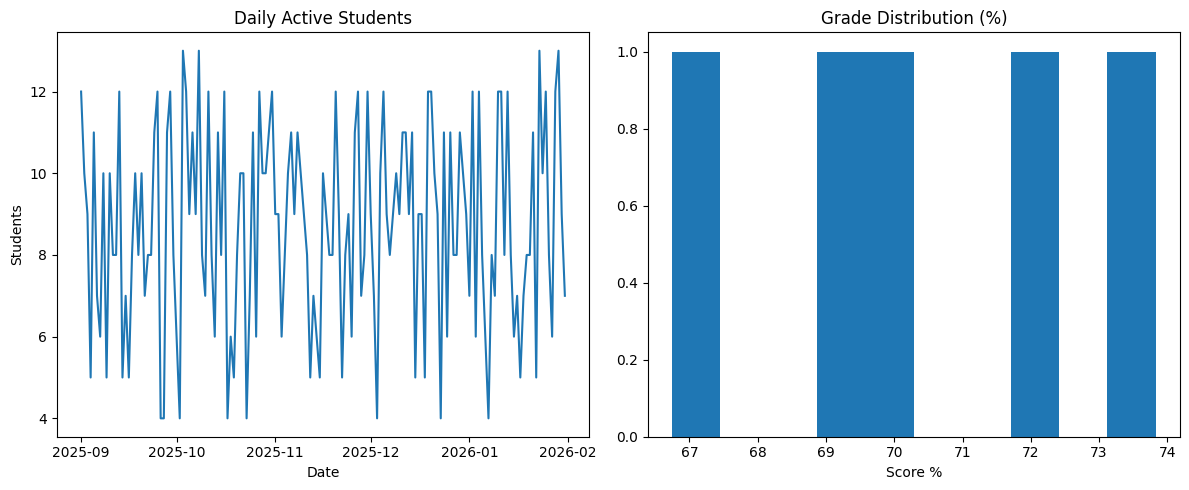


--- At-Risk Students (Top 10) ---


,user_id,risk_pct
0,81,66.666667
16,1,25.129444
2,55,23.868889
6,28,19.761944
1,76,17.896944
17,21,17.732778
20,22,17.335556
10,26,16.956667
5,12,15.846944
3,5,14.295000



--- Missing Submissions Per Student  ---


user_id
1     3
55    2
22    2
5     1
10    1
18    1
12    1
26    1
21    1
28    1
45    1
70    1
76    1
dtype: int64

In [3]:
# 1. TOTAL STUDENTS
total_students = enrol[enrol.course_id==course_id]['user_id'].nunique()


# 2. DAILY ACTIVE STUDENTS (LINE CHART)
active_trend = (
    events[events.course_id==course_id]
    .assign(date=events['timestamp'].dt.date)
    .groupby('date')['user_id']
    .nunique()
)


# 3. AVG GRADE (CLASS %)
g = grade[grade.course_id==course_id]
avg_grade_pct = (g.score/g.maxscore).mean()*100 if len(g) else 0


# 4. GRADE DISTRIBUTION (HISTOGRAM)
assignment_avg = (
    g.assign(pct=(g.score/g.maxscore)*100)
     .groupby('item_id')['pct']
     .mean()
)


# 5. MISSING PER STUDENT
s = subm[subm.course_id==course_id]

missing = s[
    (s.submitted_at.isna()) &
    (s.duedate.dt.date < today)
]

missing_per_student = (
    missing.groupby('user_id')
    .size()
    .sort_values(ascending=False)
)

# 6. AT-RISK STUDENTS (simple risk)
risk_rows = []

for uid in enrol[enrol.course_id==course_id]['user_id'].unique():

    # ---------- grade risk ----------
    stu_grade = g[g.user_id==uid]
    avg_pct = (stu_grade.score/stu_grade.maxscore).mean()*100 if len(stu_grade) else 0
    grade_risk = 100 - avg_pct

    # ---------- missing risk ----------
    miss_cnt = missing_per_student.get(uid, 0)
    missing_risk = min(100, miss_cnt*10)

    # ---------- inactivity risk ----------
    last = events[
        (events.course_id==course_id) &
        (events.user_id==uid)
    ]['timestamp'].max()

    inactivity = (today - last.date()).days if pd.notna(last) else 30
    inactivity_risk = min(100, inactivity/30*100)

    risk = (grade_risk + missing_risk + inactivity_risk) / 3 * (100 /100)

    risk_rows.append((uid, risk))

risk_df = (
    pd.DataFrame(risk_rows, columns=['user_id','risk_pct'])
      .sort_values('risk_pct', ascending=False)
)



# 7. COURSE RATING
rating_row = rating_df[rating_df.course_id==course_id]

if len(rating_row):
    avg_rating = rating_row['avg_rating'].iat[0]
    num_ratings = rating_row['num_ratings'].iat[0]
else:
    avg_rating, num_ratings = 0, 0  

# KPI CARDS 
print("\n========== TEACHER DASHBOARD ==========")
print(f"Course: {course_name}")
print(f"Total students: {total_students}")
print(f"Avg grade (class): {avg_grade_pct:.1f}%")
print(f"Missing submissions: {len(missing)}")
print(f"Course rating: Start {avg_rating} ({num_ratings} ratings)")


# CHARTS
plt.figure(figsize=(12,5))

#  Daily Active Line 
plt.subplot(1,2,1)
active_trend.plot()
plt.title("Daily Active Students")
plt.ylabel("Students")
plt.xlabel("Date")

#  Grade Distribution Histogram 
plt.subplot(1,2,2)
plt.hist(assignment_avg, bins=10)
plt.title("Grade Distribution (%)")
plt.xlabel("Score %")

plt.tight_layout()
plt.show()



# TABLES 

print("\n--- At-Risk Students (Top 10) ---")
display(risk_df.head(10))

print("\n--- Missing Submissions Per Student  ---")
display(missing_per_student)

## Teacher DASHBOARD KPIs overall

In [10]:
# ================= Teacher DASHBOARD KPIs overall =================
# ================================
# CONFIG
# ================================
TEACHER_ID = user_dim[user_dim.role == 'teacher']['user_id'].iloc[0]

# ================================
# COURSES MANAGED BY TEACHER (demo assumption via enrol_fact)
# ================================
teacher_courses = enrol[enrol.user_id == TEACHER_ID]['course_id'].unique()

# students enrolled in teacher's courses
students_in_teacher_courses = enrol[enrol.course_id.isin(teacher_courses)]['user_id'].unique()

# ================================
# TOTAL STUDENTS & COURSES
# ================================
total_students = len(students_in_teacher_courses)
total_courses = len(teacher_courses)

# ================================
# INACTIVE STUDENTS ? 7 DAYS (teacher courses)
# ================================
last_activity = (
    events[events.user_id.isin(students_in_teacher_courses)]
    .groupby('user_id')['timestamp']
    .max()
    .reset_index()
)

inactive_students_7d = last_activity[
    last_activity['timestamp'].dt.date < today - timedelta(days=7)
]['user_id'].nunique()

# ================================
# RISK (%) = SIMPLE RISK (grade + missing + inactivity)
# ================================
g = grade[grade.course_id.isin(teacher_courses)]
s = subm[subm.course_id.isin(teacher_courses)]
missing = s[(s.submitted_at.isna()) & (s.duedate.dt.date < today)]
missing_per_student = (
    missing.groupby('user_id').size().sort_values(ascending=False)
)

risk_rows = []
for uid in students_in_teacher_courses:
    # ---------- grade risk ----------
    stu_grade = g[g.user_id==uid]
    avg_pct = (stu_grade.score/stu_grade.maxscore).mean()*100 if len(stu_grade) else 0
    grade_risk = 100 - avg_pct

    # ---------- missing risk ----------
    miss_cnt = missing_per_student.get(uid, 0)
    missing_risk = min(100, miss_cnt*10)

    # ---------- inactivity risk ----------
    last = events[
        (events.course_id.isin(teacher_courses)) &
        (events.user_id==uid)
    ]['timestamp'].max()

    inactivity = (today - last.date()).days if pd.notna(last) else 30
    inactivity_risk = min(100, inactivity/30*100)

    risk = (grade_risk + missing_risk + inactivity_risk) / 3
    risk_rows.append((uid, risk))

risk_df = (
    pd.DataFrame(risk_rows, columns=['user_id','risk_pct'])
      .sort_values('risk_pct', ascending=False)
)

at_risk_threshold = 60
at_risk_count = int((risk_df['risk_pct'] > at_risk_threshold).sum())
at_risk_pct = round(100 * at_risk_count / len(risk_df), 2) if len(risk_df) else 0

# ================================
# AVG LEARNING HOURS (ONLY TEACHER'S COURSES)
# ================================
events_tc = events[events.user_id.isin(students_in_teacher_courses)].copy()
events_tc = events_tc[events_tc.course_id.isin(teacher_courses)]
events_tc.sort_values(['user_id','timestamp'], inplace=True)
events_tc['next_ts'] = events_tc.groupby('user_id')['timestamp'].shift(-1)
events_tc['session_gap_min'] = (
    (events_tc.next_ts - events_tc.timestamp)
    .dt.total_seconds() / 60
)
events_tc = events_tc[events_tc.session_gap_min.between(1, 30)]
avg_learning_hours = round(events_tc.session_gap_min.mean() / 60, 2)

# ================================
# UNGRADED SUBMISSIONS (COUNT) - teacher courses only
# ================================
submitted = s[s.submitted_at.notna()].copy()
submitted['is_overdue'] = submitted['duedate'].dt.date < today
graded_keys = g[['course_id','user_id','item_id']]
merged = submitted.merge(
    graded_keys,
    left_on=['course_id','user_id','activity_id'],
    right_on=['course_id','user_id','item_id'],
    how='left',
    indicator=True
)
overdue_ungraded = merged[(merged.is_overdue) & (merged._merge == 'left_only')]
ungraded_submissions = overdue_ungraded.shape[0]

# ================================
# FINAL KPI TABLE
# ================================
kpi_summary = pd.DataFrame([{
    'total_students': total_students,
    'total_courses': total_courses,
    'inactive_students_7d': inactive_students_7d,
    'at_risk_pct': at_risk_pct,
    'at_risk_count': at_risk_count,
    'avg_learning_hours_teacher_courses': avg_learning_hours,
    'ungraded_submissions': ungraded_submissions
}])

print('Total students:', kpi_summary['total_students'][0])
print('Total courses:', kpi_summary['total_courses'][0])
print('Inactive students (7d):', kpi_summary['inactive_students_7d'][0])
print('At-risk %:', kpi_summary['at_risk_pct'][0])
print('At-risk count:', kpi_summary['at_risk_count'][0])
print('Avg learning hours:', kpi_summary['avg_learning_hours_teacher_courses'][0])
print('Ungraded submissions:', kpi_summary['ungraded_submissions'][0])


Total students: 23
Total courses: 1
Inactive students (7d): 0
At-risk %: 4.35
At-risk count: 1
Avg learning hours: 0.25
Ungraded submissions: 0


## Investor — KPIs


========== INVESTOR DASHBOARD ==========
Date context (today): 2026-01-31

--- CARDS ---
Total ideas: 30
Ready to invest (score >= 80): 6
New ideas (last 7 days): 0
Avg pitch score: 68.4

--- RANKING TABLE (Top 50 ideas) ---


,idea_id,title,domain_code,stage,score_0_100,mentor_id,last_update,investor_status
22,23,Idea 23,ai,mvp,94.0,87.0,2026-01-14,None
14,15,Idea 15,fintech,prototype,91.0,88.0,2025-12-13,None
10,11,Idea 11,ai,prototype,91.0,89.0,2025-10-13,None
26,27,Idea 27,edtech,prototype,87.0,88.0,2025-12-02,None
27,28,Idea 28,health,mvp,81.0,89.0,2025-12-17,None
17,18,Idea 18,sustainability,idea,80.0,89.0,2025-10-15,None
28,29,Idea 29,edtech,growth,78.0,87.0,2025-10-23,None
15,16,Idea 16,health,growth,76.0,89.0,2025-12-13,None
23,24,Idea 24,edtech,prototype,76.0,87.0,2025-11-06,None
4,5,Idea 5,ai,prototype,73.0,87.0,2026-01-02,None


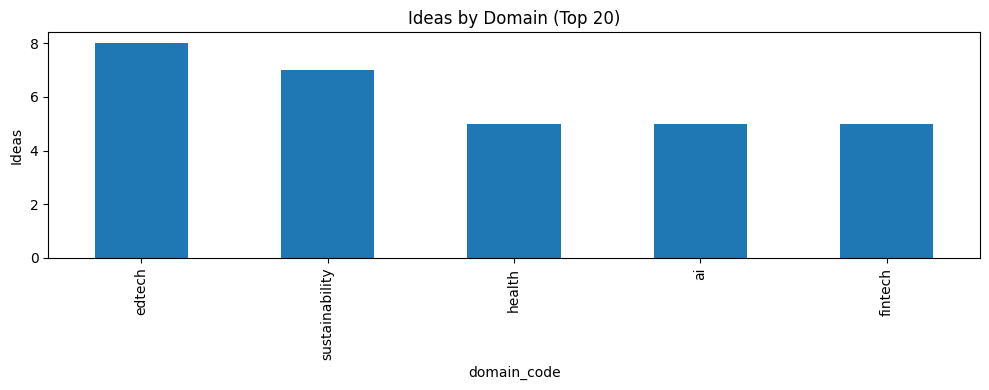

In [4]:
START_7D = today - timedelta(days=7)
mentor_match = None
try:
    mentor_match = pd.read_csv(BASE/'mentor_match.csv', parse_dates=['matched_at'])
except Exception:
    mentor_match = None

mentor_profile = None
try:
    mentor_profile = pd.read_csv(BASE/'mentor_profile.csv')
except Exception:
    mentor_profile = None

# Optional: investor matching (admin connects ideas to investors)
investor_match = None
try:
    investor_match = pd.read_csv(BASE/'investor_match.csv', parse_dates=['matched_at'])
except Exception:
    investor_match = None

# ---------
# CONFIG
# ---------
READY_THRESHOLD = 80

# --- Normalize column names (small safety) ---
# Expect idea columns: idea_id, student_userid, domain_code, title, stage, created_at
# If your generator uses student_id instead of student_userid, map it.
if 'student_id' in idea.columns and 'student_userid' not in idea.columns:
    idea = idea.rename(columns={'student_id': 'student_userid'})

# Pitch expects: match_id or idea_id. We'll support both.
pitch_cols = set(pitch.columns)

# If pitch is tied to match_id, but we want idea_id: join via mentor_match (idea_id <-> match_id)
pitch_idea = None
if 'idea_id' in pitch_cols:
    pitch_idea = pitch[['idea_id','score_0_100']].copy()
elif 'match_id' in pitch_cols and mentor_match is not None and {'match_id','idea_id'}.issubset(mentor_match.columns):
    pitch_idea = (
        pitch[['match_id','score_0_100']]
        .merge(mentor_match[['match_id','idea_id']], on='match_id', how='left')
        [['idea_id','score_0_100']]
        .dropna(subset=['idea_id'])
    )
else:
    # No usable join: create empty pitch_idea so code runs
    pitch_idea = pd.DataFrame(columns=['idea_id','score_0_100'])

pitch_idea['idea_id'] = pitch_idea['idea_id'].astype(int, errors='ignore')

# --- Cards ---
total_ideas = len(idea)

new_ideas_7d = 0
if 'created_at' in idea.columns:
    # created_at may be NaT if parse failed
    created = pd.to_datetime(idea['created_at'], errors='coerce')
    new_ideas_7d = int((created.dt.date >= START_7D).sum())
else:
    new_ideas_7d = None

ready_ideas_cnt = int((pitch_idea['score_0_100'] >= READY_THRESHOLD).sum()) if len(pitch_idea) else 0
avg_pitch = float(pitch_idea['score_0_100'].mean()) if len(pitch_idea) else None

print("\n========== INVESTOR DASHBOARD ==========")
print(f"Date context (today): {today}")
print("\n--- CARDS ---")
print(f"Total ideas: {total_ideas}")
print(f"Ready to invest (score >= {READY_THRESHOLD}): {ready_ideas_cnt}")
print(f"New ideas (last 7 days): {new_ideas_7d if new_ideas_7d is not None else 'N/A'}")
print(f"Avg pitch score: {avg_pitch:.1f}" if avg_pitch is not None else "Avg pitch score: N/A")

# --- Ranking table (deal screener) ---
rank = idea.copy()

# add pitch score
rank = rank.merge(pitch_idea, on='idea_id', how='left')
rank['score_0_100'] = rank['score_0_100'].fillna(0)

# add mentor (optional)
if mentor_match is not None and {'idea_id','mentor_id'}.issubset(mentor_match.columns):
    rank = rank.merge(mentor_match[['idea_id','mentor_id']], on='idea_id', how='left')
else:
    rank['mentor_id'] = None

# add "last update" proxy:
# Prefer action items or events if available; fallback to created_at.
last_update = None

# try action_item (execution)
action_item = None
try:
    action_item = pd.read_csv(BASE/'action_item.csv', parse_dates=['due_date','done_at'])
except Exception:
    action_item = None

if action_item is not None and mentor_match is not None and {'match_id','idea_id'}.issubset(mentor_match.columns) and 'match_id' in action_item.columns:
    # last update from done_at or due_date as proxy
    ai = action_item.copy()
    ai['ts'] = pd.to_datetime(ai['done_at'], errors='coerce')
    # if done_at missing, use due_date as a weak proxy of "current planning"
    ai.loc[ai['ts'].isna(), 'ts'] = pd.to_datetime(ai.loc[ai['ts'].isna(), 'due_date'], errors='coerce')
    last_update = (
        ai.merge(mentor_match[['match_id','idea_id']], on='match_id', how='left')
          .groupby('idea_id')['ts'].max()
    )
    rank['last_update'] = rank['idea_id'].map(last_update)
elif len(events) and 'user_id' in events.columns:
    # fallback: last activity by student
    ev_last = events.groupby('user_id')['timestamp'].max()
    rank['last_update'] = rank['student_userid'].map(ev_last)
else:
    rank['last_update'] = pd.to_datetime(rank['created_at'], errors='coerce') if 'created_at' in rank.columns else pd.NaT

# add investor match status (optional)
if investor_match is not None and 'idea_id' in investor_match.columns:
    # if multiple rows, take latest status
    inv = investor_match.copy()
    if 'matched_at' in inv.columns:
        inv = inv.sort_values('matched_at')
    latest = inv.groupby('idea_id').tail(1)
    if 'status' in latest.columns:
        rank = rank.merge(latest[['idea_id','status']].rename(columns={'status':'investor_status'}), on='idea_id', how='left')
    else:
        rank['investor_status'] = None
else:
    rank['investor_status'] = None

# select display columns (safe)
show_cols = []
for c in ['idea_id','title','domain_code','stage','score_0_100','mentor_id','last_update','investor_status']:
    if c in rank.columns:
        show_cols.append(c)

rank_table = (
    rank[show_cols]
    .sort_values(['score_0_100','last_update'], ascending=[False, False])
    .head(50)
)

print("\n--- RANKING TABLE (Top 50 ideas) ---")
display(rank_table)

# --- 1 Bar chart: Ideas by domain (showcase supply) ---
if 'domain_code' in idea.columns and len(idea):
    domain_counts = idea['domain_code'].fillna('unknown').value_counts().head(20)
    plt.figure(figsize=(10,4))
    domain_counts.plot(kind='bar')
    plt.title("Ideas by Domain (Top 20)")
    plt.ylabel("Ideas")
    plt.tight_layout()
    plt.show()
else:
    print("\nIdeas by Domain chart: N/A (no domain_code)")

## Admin — KPI + Chart (Logs)
- KPI: log volume per day, event mix
- Chart: line log volume, stacked event types


--- A) SYSTEM ---
Total accounts: 91
Concurrent users now (proxy, 5-min window): 1
Peak concurrent (proxy, last event day): 4
Error rate proxy: 1 errors (latest day)
DB size growth: 644.5 MB (latest)

--- B) USERS / POLICY ---
Blocked users: 4

--- C) SMART MATCHING ---
Unmatched ideas: 8
Ready-to-invest ideas (score>=80): 6
Available mentors today: 0

--- Mentor Availability Today (with skill) ---


,mentor_id,free_slots,primary_domain_code



--- Unmatched Ideas ---


,idea_id,student_userid,domain_code,title,stage,created_at
2,3,15,health,Idea 3,prototype,2025-09-01
3,4,22,edtech,Idea 4,mvp,2025-09-01
7,8,33,sustainability,Idea 8,prototype,2025-09-01
18,19,43,fintech,Idea 19,mvp,2025-09-01
19,20,6,ai,Idea 20,growth,2025-09-01
20,21,77,fintech,Idea 21,prototype,2025-09-01
24,25,40,fintech,Idea 25,mvp,2025-09-01
25,26,24,sustainability,Idea 26,idea,2025-09-01


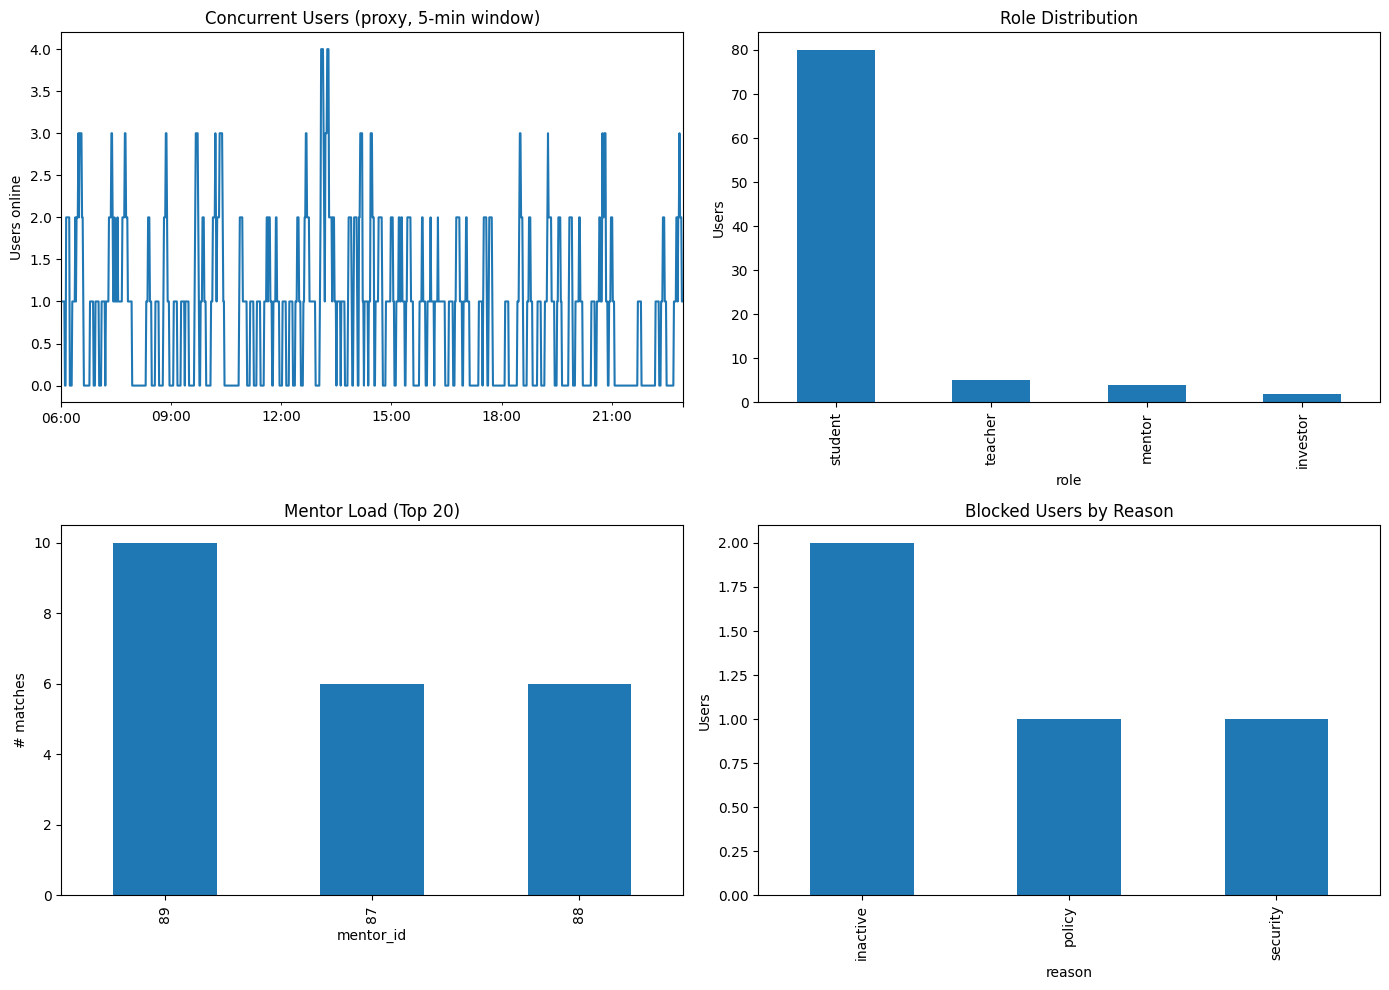

In [5]:
# A) SYSTEM

total_accounts = len(user_dim)

# Concurrent users proxy (distinct users with any event in last 5 minutes, per minute timeline)
if len(events):
    ev = events[['timestamp','user_id']].dropna().sort_values('timestamp')
    last_day = ev['timestamp'].dt.date.max()
    ev_day = ev[ev['timestamp'].dt.date == last_day].copy().set_index('timestamp')

    # Minute index for last_day
    idx = pd.date_range(
        start=ev_day.index.min().floor('min'),
        end=ev_day.index.max().ceil('min'),
        freq='1min'
    )

    # Exact distinct users in rolling 5-min window using two pointers
    pairs = ev_day.reset_index()[['timestamp','user_id']].sort_values('timestamp').to_records(index=False)
    ts = pairs['timestamp']
    uids = pairs['user_id']
    n = len(pairs)

    from collections import defaultdict
    left = 0
    right = 0
    counts = defaultdict(int)
    conc_values = []

    for t in idx:
        window_start = t - pd.Timedelta(minutes=5)
        while right < n and ts[right] <= t:
            counts[uids[right]] += 1
            right += 1
        while left < n and ts[left] < window_start:
            uid = uids[left]
            counts[uid] -= 1
            if counts[uid] <= 0:
                del counts[uid]
            left += 1
        conc_values.append(len(counts))

    concurrent_series = pd.Series(conc_values, index=idx)
    current_concurrent = int(concurrent_series.iloc[-1]) if len(concurrent_series) else 0
    peak_concurrent = int(concurrent_series.max()) if len(concurrent_series) else 0
else:
    concurrent_series = pd.Series(dtype=float)
    current_concurrent, peak_concurrent = 0, 0

# Error rate proxy (errors/day)
if error_log is not None and len(error_log):
    error_log['date'] = error_log['timestamp'].dt.date
    errors_per_day = error_log.groupby('date').size()
    current_errors = int(errors_per_day.iloc[-1])
else:
    errors_per_day = None
    current_errors = None

# DB size growth (db_size_mb/day)
if db_metrics is not None and len(db_metrics) and 'db_size_mb' in db_metrics.columns:
    db_metrics = db_metrics.sort_values('date')
    db_size_series = db_metrics.set_index(db_metrics['date'].dt.date)['db_size_mb']
    current_db_size = float(db_size_series.iloc[-1])
else:
    db_size_series = None
    current_db_size = None


# B) USERS / POLICY

role_dist = user_dim['role'].value_counts(dropna=False) if 'role' in user_dim.columns else pd.Series(dtype=int)

if user_status is not None and len(user_status) and {'status','reason'}.issubset(user_status.columns):
    blocked = user_status[user_status['status'].astype(str).str.lower()=='blocked'].copy()
    blocked_by_reason = blocked['reason'].fillna('unknown').value_counts()
    blocked_count = int(len(blocked))
else:
    blocked_by_reason = None
    blocked_count = None


# C) SMART MATCHING

THRESHOLD_READY = 80

# Unmatched ideas
if idea is not None and match is not None and len(idea) and 'idea_id' in idea.columns and 'idea_id' in match.columns:
    matched_ids = set(match['idea_id'].dropna().astype(int).unique())
    idea_ids = set(idea['idea_id'].dropna().astype(int).unique())
    unmatched_ids = sorted(list(idea_ids - matched_ids))
    unmatched_ideas = idea[idea['idea_id'].isin(unmatched_ids)].copy()
    unmatched_count = len(unmatched_ids)
else:
    unmatched_ideas = None
    unmatched_count = None

# Ready-to-invest ideas
if pitch is not None and len(pitch) and 'score_0_100' in pitch.columns:
    ready_to_invest = pitch[pitch['score_0_100'] >= THRESHOLD_READY].copy()
    ready_count = len(ready_to_invest)
else:
    ready_to_invest = None
    ready_count = None

# Mentor load
if match is not None and len(match) and 'mentor_id' in match.columns:
    mentor_load = match.groupby('mentor_id').size().sort_values(ascending=False)
else:
    mentor_load = None

# Mentor skill categories
if mentor_profile is not None and len(mentor_profile) and 'primary_domain_code' in mentor_profile.columns:
    mentor_skill = mentor_profile['primary_domain_code'].fillna('unknown').value_counts()
else:
    mentor_skill = None

# Mentor availability today (count + table with skill)
if mentor_avail is not None and len(mentor_avail) and {'mentor_id','start_time','is_free'}.issubset(mentor_avail.columns):
    mentor_avail['date'] = mentor_avail['start_time'].dt.date
    today_slots = mentor_avail[(mentor_avail['date']==today) & (mentor_avail['is_free']==True)].copy()
    availability_today = today_slots.groupby('mentor_id').size().rename('free_slots').sort_values(ascending=False)

    available_mentors_today = int((availability_today > 0).sum())

    # join skill (optional)
    avail_table = availability_today.reset_index()
    if mentor_profile is not None and 'mentor_id' in mentor_profile.columns and 'primary_domain_code' in mentor_profile.columns:
        avail_table = avail_table.merge(
            mentor_profile[['mentor_id','primary_domain_code']],
            on='mentor_id',
            how='left'
        )
    else:
        avail_table['primary_domain_code'] = None
else:
    availability_today = None
    avail_table = None
    available_mentors_today = 0


# PRINT OUTPUT (exact style)

print("\n--- A) SYSTEM ---")
print(f"Total accounts: {total_accounts}")
print(f"Concurrent users now (proxy, 5-min window): {current_concurrent}")
print(f"Peak concurrent (proxy, last event day): {peak_concurrent}")
print(f"Error rate proxy: {'N/A' if current_errors is None else str(current_errors)+' errors (latest day)'}")
print(f"DB size growth: {'N/A' if current_db_size is None else f'{current_db_size:.1f} MB (latest)'}")

print("\n--- B) USERS / POLICY ---")
print(f"Blocked users: {'N/A' if blocked_count is None else blocked_count}")

print("\n--- C) SMART MATCHING ---")
print(f"Unmatched ideas: {'N/A' if unmatched_count is None else unmatched_count}")
print(f"Ready-to-invest ideas (score>={THRESHOLD_READY}): {'N/A' if ready_count is None else ready_count}")
print(f"Available mentors today: {available_mentors_today}")

# Tables
print("\n--- Mentor Availability Today (with skill) ---")
if avail_table is not None and len(avail_table):
    # show top 50
    display(avail_table[['mentor_id','free_slots','primary_domain_code']].head(50))
else:
    display(pd.DataFrame(columns=['mentor_id','free_slots','primary_domain_code']))

print("\n--- Unmatched Ideas ---")
if unmatched_ideas is not None and len(unmatched_ideas):
    cols = [c for c in ['idea_id','student_userid','domain_code','title','stage','created_at'] if c in unmatched_ideas.columns]
    display(unmatched_ideas[cols].head(50))
else:
    display(pd.DataFrame(columns=['idea_id','student_userid','domain_code','title','stage','created_at']))


# CHARTS (lean)

plt.figure(figsize=(14,10))

# (1) Concurrent users
plt.subplot(2,2,1)
if len(concurrent_series):
    concurrent_series.plot()
    plt.title("Concurrent Users (proxy, 5-min window)")
    plt.ylabel("Users online")
else:
    plt.title("Concurrent Users - N/A")
    plt.text(0.5,0.5,"No events data", ha='center', va='center', transform=plt.gca().transAxes)

# (2) Role distribution
plt.subplot(2,2,2)
if len(role_dist):
    role_dist.plot(kind='bar')
    plt.title("Role Distribution")
    plt.ylabel("Users")
else:
    plt.title("Role Distribution - N/A")
    plt.text(0.5,0.5,"No role column", ha='center', va='center', transform=plt.gca().transAxes)

# (3) Mentor load
plt.subplot(2,2,3)
if mentor_load is not None and len(mentor_load):
    mentor_load.head(20).plot(kind='bar')
    plt.title("Mentor Load (Top 20)")
    plt.ylabel("# matches")
else:
    plt.title("Mentor Load - N/A")
    plt.text(0.5,0.5,"No mentor_match data", ha='center', va='center', transform=plt.gca().transAxes)

# (4) Blocked by reason OR Mentor skill categories
plt.subplot(2,2,4)
if blocked_by_reason is not None and len(blocked_by_reason):
    blocked_by_reason.plot(kind='bar')
    plt.title("Blocked Users by Reason")
    plt.ylabel("Users")
elif mentor_skill is not None and len(mentor_skill):
    mentor_skill.plot(kind='bar')
    plt.title("Mentor Skill Categories")
    plt.ylabel("Mentors")
else:
    plt.title("Blocked by Reason / Mentor Skill - N/A")
    plt.text(0.5,0.5,"No user_status & no mentor_profile", ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


## Mentor — KPIs (Tiến độ mentee, Tương tác/tuần)
- Chart: Progress per mentee (completion proxy), Interaction per week

In [6]:
mentor_id = mentor_profile['mentor_id'].iloc[0]


# 1) GET MY MENTEES

my_match = match[match.mentor_id == mentor_id]

mentees = (
    my_match
    .merge(idea, on='idea_id') 
    .merge(user_dim[['user_id','fullname']],
           left_on='student_userid', right_on='user_id')
)

total_mentees = len(mentees)


# 2) LAST ACTIVE

last_active = (
    events.groupby('user_id')['timestamp']
    .max()
)

mentees['last_active'] = mentees['user_id'].map(last_active)
today_ts = pd.to_datetime(pd.Timestamp.today().date())
mentees['days_inactive'] = (today_ts - mentees['last_active']).dt.days
mentees['days_inactive'] = mentees['days_inactive'].fillna(999)


# 3) PROGRESS

done_cnt = actions[actions.status=='done'].groupby('match_id').size()
total_cnt = actions.groupby('match_id').size()
progress = (done_cnt / total_cnt * 100).fillna(0)

mentees['progress_pct'] = mentees['match_id'].map(progress).fillna(0)


# 4) OVERDUE ACTIONS

actions['due_date'] = pd.to_datetime(actions['due_date'])
overdue = actions[(actions.status!='done') & (actions.due_date < today_ts)]
overdue_cnt = overdue.groupby('match_id').size()
mentees['overdue_actions'] = mentees['match_id'].map(overdue_cnt).fillna(0)


# 5) PITCH READINESS
pitch_score = pitch.set_index('match_id')['score_0_100']
mentees['pitch_score'] = mentees['match_id'].map(pitch_score).fillna(0)


# 6) SIMPLE RISK

grade_avg = (
    grade.assign(pct=(grade.score/grade.maxscore)*100)
    .groupby('user_id')['pct']
    .mean()
)
mentees['avg_grade'] = mentees['user_id'].map(grade_avg).fillna(0)

grade_risk = 100 - mentees['avg_grade']
inactive_risk = (mentees['days_inactive']/30*100).clip(0,100)
overdue_risk = (mentees['overdue_actions']*10).clip(0,100)

mentees['risk_pct'] = (grade_risk + inactive_risk + overdue_risk) / 3

print("\n========== MENTOR DASHBOARD ==========")
print(f"My mentees: {total_mentees}")
print(f"Active this week: {(mentees.days_inactive<=7).sum()}")
print(f"At-risk (>60%): {(mentees.risk_pct>60).sum()}")
print(f"Open actions: {(actions.status!='done').sum()}")

mentor_table = mentees[['student_userid','fullname','risk_pct','progress_pct',
                        'overdue_actions','days_inactive','pitch_score']].sort_values('risk_pct', ascending=False)

display(mentor_table)


========== MENTOR DASHBOARD ==========
My mentees: 10
Active this week: 3
At-risk (>60%): 6
Open actions: 28


,student_userid,fullname,risk_pct,progress_pct,overdue_actions,days_inactive,pitch_score
4,3,Student 003,76.666667,0.000000,3.0,999.0,59
5,66,Student 066,73.333333,33.333333,2.0,999.0,76
8,53,Student 053,73.333333,50.000000,2.0,999.0,53
7,63,Student 063,70.000000,66.666667,1.0,999.0,80
2,37,Student 037,70.000000,0.000000,1.0,999.0,42
3,68,Student 068,70.000000,0.000000,1.0,999.0,91
1,74,Student 074,23.011389,0.000000,2.0,5.0,41
0,78,Student 078,17.224167,100.000000,0.0,9.0,53
9,48,Student 048,16.014167,66.666667,1.0,3.0,81
6,38,Student 038,14.017778,100.000000,0.0,4.0,59


## Mentor for UI


In [12]:
# Mentor UI KPIs (per mentor)
MENTOR_ID = mentor_profile['mentor_id'].iloc[0]
READY_THRESHOLD = 80
NEW_DAYS = 7

# ideas/mentees managed by this mentor
my_match = match[match.mentor_id == MENTOR_ID].copy()
my_ideas = idea[idea.idea_id.isin(my_match.idea_id)].copy()

idea_count = int(my_ideas['idea_id'].nunique())
mentee_count = int(my_ideas['student_userid' if 'student_userid' in my_ideas.columns else 'student_id'].nunique())

# pitch ready = deal ready (proxy)
pitch_ready_cnt = 0
if 'match_id' in pitch.columns:
    pitch_ready_cnt = int((
        pitch[pitch.match_id.isin(my_match.match_id)]['score_0_100'] >= READY_THRESHOLD
    ).sum())

# new ideas connected to mentor (recent matches)
matched_recent = my_match[my_match['matched_at'] >= (pd.Timestamp(today) - pd.Timedelta(days=NEW_DAYS))]
new_ideas_cnt = int(matched_recent['idea_id'].nunique())

print("========== MENTOR UI KPIs ==========")
print(f"Mentor ID: {MENTOR_ID}")
print(f"Ideas managed: {idea_count}")
print(f"Mentees managed: {mentee_count}")
print(f"Deal-ready ideas (pitch >= {READY_THRESHOLD}): {pitch_ready_cnt}")
print(f"New ideas (last {NEW_DAYS} days): {new_ideas_cnt}")


========== MENTOR UI KPIs ==========
Mentor ID: 89
Ideas managed: 10
Mentees managed: 10
Deal-ready ideas (pitch >= 80): 3
New ideas (last 7 days): 0
